# Sheet 4
Handed in by Benny Bauer and Anton Schwarz

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

# 1) Learning with pytorch

### a) Foreward and backward passes

In [222]:
# TODO: manual check of intermediate gradients with torch.autograd.grad
x = torch.tensor(0.5, requires_grad=True)
y = torch.tensor(1.5, requires_grad=True)


In [212]:
def Loss(a, b):
    return (torch.sin(a / b) + a / b - torch.exp(b)) * (a / b - torch.exp(b))

In [213]:
torch.autograd.grad(Loss(x, y), x)

(tensor(-7.9264),)

In [215]:
frac = x / y
sinf = torch.sin(frac)
expy = torch.exp(y)
lprt = sinf + frac - expy
rprt = frac - expy
L = lprt * rprt
for (tensor, name) in zip(
        (x, y, frac, sinf, expy, lprt, rprt),
        ('x', 'y', 'x/y', 'sin(x/y)', 'exp(y)', 'sin(x/y) + x/y - exp(y)', 'x/y - exp(y)')
    ):
    print(f"{name} has grad_fn {torch.autograd.grad(L, tensor, create_graph=True)[0]:.3f} and foreward pass value {tensor.data:.3f}")

x has grad_fn -7.926 and foreward pass value 0.500
y has grad_fn 38.359 and foreward pass value 1.500
x/y has grad_fn -11.890 and foreward pass value 0.333
sin(x/y) has grad_fn -4.148 and foreward pass value 0.327
exp(y) has grad_fn 7.970 and foreward pass value 4.482
sin(x/y) + x/y - exp(y) has grad_fn -4.148 and foreward pass value -3.821
x/y - exp(y) has grad_fn -3.821 and foreward pass value -4.148


### b) Two optimisation steps with Adam

Remember the process:
1. set up loss function
1. Set up optimiser, tell it which parameters to optimise.

Now loop over:
  1. Zero-grad the optimiser
  2. Calculate loss function (returns tensor)
  3. Run the tensor backward
  4. Do the optimiser step. This automatically takes the loss data and also updates the parameters.

In [235]:
# TODO: Adam steps
# re-initialise x, y
x = torch.tensor(0.5, requires_grad=True)
y = torch.tensor(1.5, requires_grad=True)
# skipping the part where we do lr=0.1 and only two steps.
adam_optimiser = torch.optim.Adam([x, y], lr=0.001)

loss_history = []

myiter = tqdm(range(1000));
for i in myiter:
    adam_optimiser.zero_grad()
    L = Loss(x, y)
    L.backward()
    adam_optimiser.step()
    loss_history.append(L.item())
    myiter.set_description(f"Adam step {i} with loss {L:.3f} and x={x.data:.3f}, y={y.data:.3f}");

Adam step 6 with loss 15.575 and x=0.507, y=1.493:   0%|          | 0/1000 [00:00<?, ?it/s]

Adam step 999 with loss 0.046 and x=1.214, y=0.878: 100%|██████████| 1000/1000 [00:03<00:00, 319.87it/s]


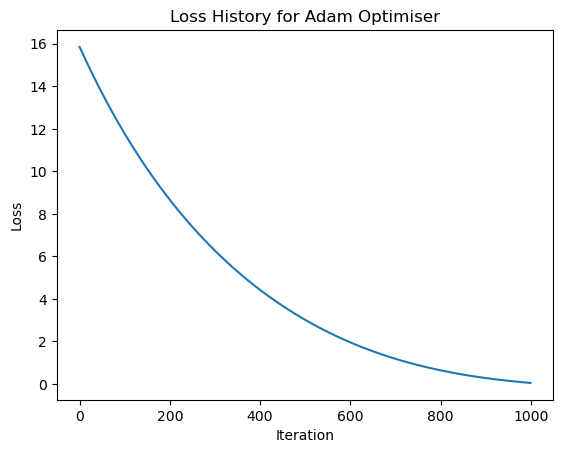

In [237]:
# TODO: Plot the loss
plt.plot(loss_history);
plt.title("Loss History for Adam Optimiser")
plt.xlabel("Iteration")
plt.ylabel("Loss");

(c)

In [251]:
# TODO: Compute gradients
xx1 = torch.linspace(0, 2, 100, requires_grad=True)
x2 = torch.tensor(0.5)

losses = Loss(xx1, x2)

In [253]:
# different ways to do this, but this is the most readable
losses.backward(torch.ones_like(xx1))

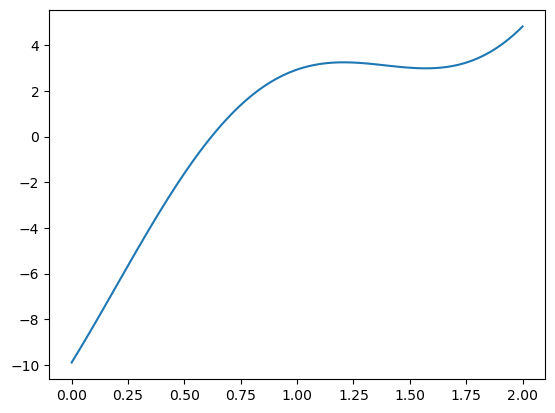

In [255]:
# TODO: Plot gradients and compare to solution for x1 from part (b)
plt.plot(xx1.detach().numpy(), xx1.grad);

We can see that the gradient zero intercept is near $x_1 \approx 0.5$, which does not agree with our result that $L$ is minimal for $x_1 \approx 1.2$.

# 2) Amplitude Regression

In [2]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
# import os, sys
# import wget
# from zipfile import ZipFile
# from tqdm import tqdm

# DESTINATION = "data04"
# url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
# filename = "tutorial-2-data.zip"
# url = url + filename

# os.makedirs(DESTINATION, exist_ok=True)
# os.chdir(DESTINATION)
# wget.download(url, filename)
# with ZipFile(filename, "r") as zip_ref:
#     for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
#         zip_ref.extract(member=file)
# os.chdir("..")
# %ls data04

In [2]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


(a)

#### Amplitude Plot

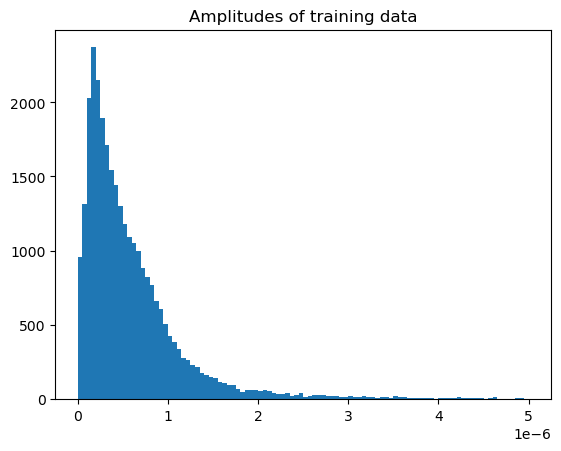

In [3]:
plt.hist(trn_amp, bins=100, range=(0, 5e-6));
plt.title("Amplitudes of training data");

#### Incoming Momenta

Text(0.5, 1.0, 'Sum of $p_z$ of the incoming particles')

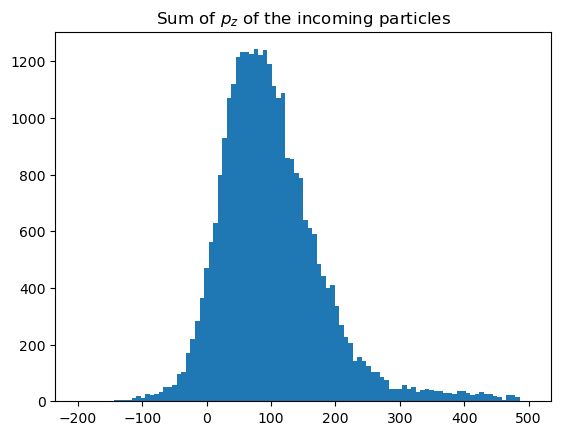

In [4]:
plt.hist(
    np.sum(trn_dat[:, [0, 1]][:, :, 3], axis=1), # for each event, select the first two particles, then sum their pz
    bins=100,
    range=(-200,500)
);
plt.title("Sum of $p_z$ of the incoming particles")

The momenta $p_{x, i}$ and $p_{y, i}$ are all zero for the incoming particles.

#### Transverse momenta of photons

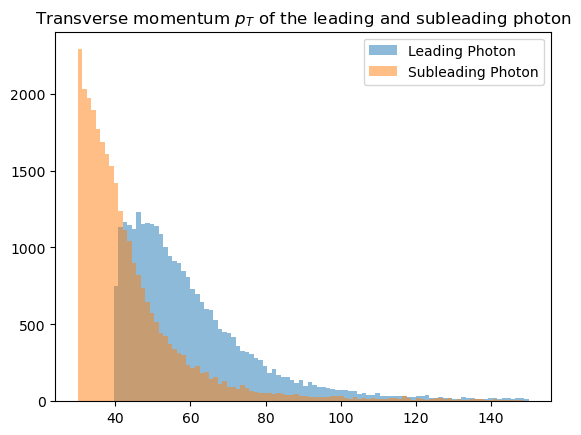

In [5]:
# TODO: Plot photon pTs
plt.hist(
    np.sqrt(np.sum(trn_dat[:, 2, [1, 2]]**2, axis=1)),
    label="Leading Photon",
    bins=100,
    range=(30, 150),
    alpha=0.5
);
plt.hist(
    np.sqrt(np.sum(trn_dat[:, 3, [1, 2]]**2, axis=1)),
    label="Subleading Photon",
    bins=100,
    range=(30, 150),
    alpha=0.5
);
plt.legend();
plt.title("Transverse momentum $p_T$ of the leading and subleading photon");

#### MET

We assume that the missing transverse energy is the negative magnitude of the vector sum of the transverse momenta of all visible outcome particles, i.e.

$$MET = - \sqrt{\left(\sum_n E_x \right)^2 + \left(\sum_n E_y\right)^2}$$

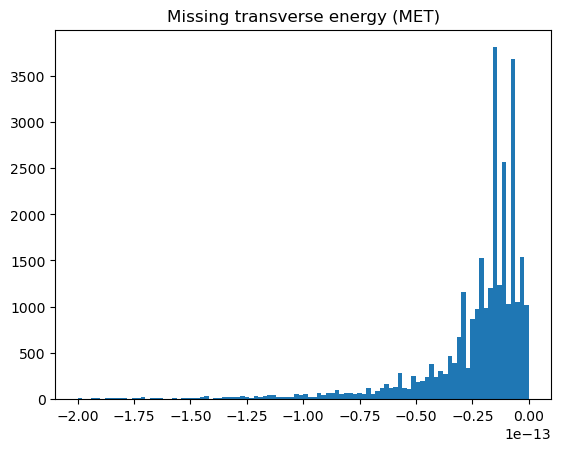

In [6]:
plt.hist(
    -np.sqrt(
        np.sum(trn_dat[:, [2, 3, 4], 1], axis=1)**2 +  # square of the sum of the px of all outgoing particles
        np.sum(trn_dat[:, [2, 3, 4], 2], axis=1)**2    # square of the sum of the py of all outgoing particles
    ),  # each entry corresponds to MET of one event
    bins=100,
    range=(-2e-13,0)
);
plt.title("Missing transverse energy (MET)");

### (b)

The following flattening steps reshape the data from
$$[p_{g1}; p_{g2}; p_{\gamma 1}; p_{\gamma 2}; p_{g3}]$$
where each particle is on a new line (which results in a matrix with columns being the 4-vector entries and rows being the particles) into a vector with 20 entries:
$$[p^{(0)}_{g1} ... p^{(3)}_{g1} p^{(0)}_{g2} ... p^{(3)}_{g3}]$$

In [7]:
# flatten datasets
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

We do not use the true maximum value of the amplitude because it is an outlier that is 4 orders of magnitude above the mean. Instead, we use a heuristic and clamp at 5e-6.

In [8]:
MAX_X = np.max(np.abs(trn_datf))
# MAX_A = np.max(np.abs(trn_amp))
MAX_A = 5e-6

def preprocess_x(x_in):
    return x_in * 5 / MAX_X

def preprocess_A(A_in):
    return A_in * 5 / MAX_A

def undo_preprocess_A(A_in):
    return A_in * MAX_A / 5

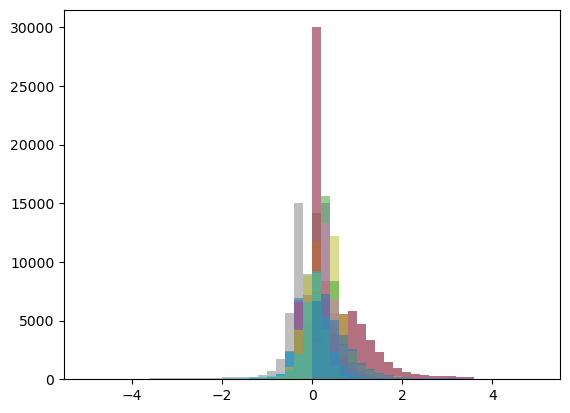

In [9]:
# check that network inputs are O(1)
for i in range(20):
    # got rid of [0][:,i] -> [0] is not needed
    plt.hist(preprocess_x(trn_datf)[:,i], range=(-5,5), alpha=.5, bins=50)
# same here, [0] is not needed
plt.hist(preprocess_A(trn_amp), range=(-5,5), alpha=.5, bins=50)
plt.show()

In [67]:
# TODO: Implement dataset class
class amp_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, amp):
        self.momenta = preprocess_x(data)
        self.amplitudes = preprocess_A(amp)

    def __len__(self):
        return len(self.amplitudes)

    def __getitem__(self, idx):
        return self.momenta[idx], self.amplitudes[idx]

In [93]:
# TODO: create datasets and dataloaders
from torch.utils.data import DataLoader

trn_dataloader = DataLoader(amp_dataset(trn_datf, trn_amp), batch_size=64, shuffle=True)
val_dataloader = DataLoader(amp_dataset(val_datf, val_amp), batch_size=64, shuffle=True)
tst_dataloader = DataLoader(amp_dataset(tst_datf, tst_amp), batch_size=64, shuffle=True)

We can iterate over these using ´next(iter(dataloader))´ or so, It returns a list, of which the first element is the data (preprocessed) and the second is the amplitude (preprocessed).

### (c)

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [138]:
# TODO: Implement network
class amp_net(nn.Module):
    
    def __init__(self, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        super(amp_net, self).__init__()
        self.input = nn.Linear(ipt_dim, hdn_dim)
        self.hidden1 = nn.Linear(hdn_dim, hdn_dim)
        self.hidden2 = nn.Linear(hdn_dim, hdn_dim)
        self.output = nn.Linear(hdn_dim, opt_dim)

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        return self.output(x)

In [142]:
# TODO: create network
model = amp_net().to(device)
# use double precision
model = model.double()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

amp_net(
  (input): Linear(in_features=20, out_features=32, bias=True)
  (hidden1): Linear(in_features=32, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)
Model has 2817 trainable parameters


In [123]:
# take first batch from train loader
x, A = next(iter(trn_dataloader))
print(x.shape, A.shape)

torch.Size([64, 20]) torch.Size([64])


In [124]:
x.shape

torch.Size([64, 20])

We now select the _loss function_. This function takes two tensors $x$, $y$ of arbitrary shape measures the mean squared error between each element in input and target.

We select the _optimiser_, and we choose the Adam algorithm with lerning rate 1e-3. We pass the model parameters first.

In [77]:
# when re-running this cell, we must re-initialise the model first.
# TODO: Train network on first batch for 10000 iterations
criterion = torch.nn.MSELoss()  # is a callable which takes tensors x, y and returns a scalar loss
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)  # is an object of class Adam

loss_history = []
a_comparison = []
myiter = tqdm(range(1000));
for i in myiter:
    # zero out the gradients which we will update (the models learnable parameters)
    # the optimiser object keeps track of the parameters which it should update
    optimiser.zero_grad()
    # get prediction for batch x
    outputs = model(x)
    # get loss of prediction relative to target A
    loss = criterion(outputs.flatten(), A)
    loss.backward()  # compute gradients of loss with respect to all learnable parameters
    # update the learnable parameters
    optimiser.step()

    loss_history.append(loss.item())
    a_comparison.append(((outputs.flatten() - A) / A).mean())

    myiter.set_description(f"Loss: {loss.item():.3f}");

  0%|          | 0/1000 [00:00<?, ?it/s]/home/anton/.anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Loss: 0.510: 100%|██████████| 1000/1000 [00:07<00:00, 133.96it/s]


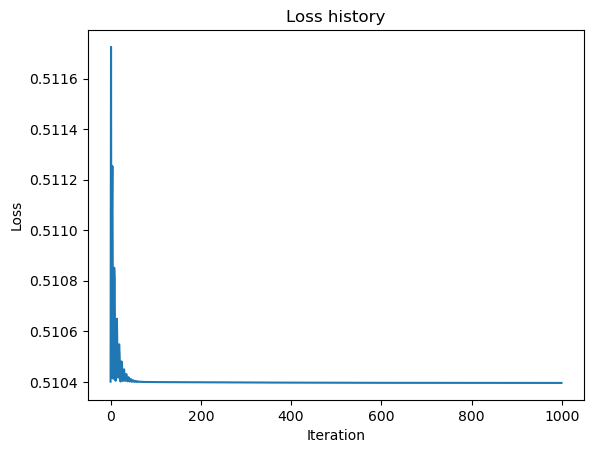

In [78]:
plt.plot(loss_history)
plt.title("Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss");

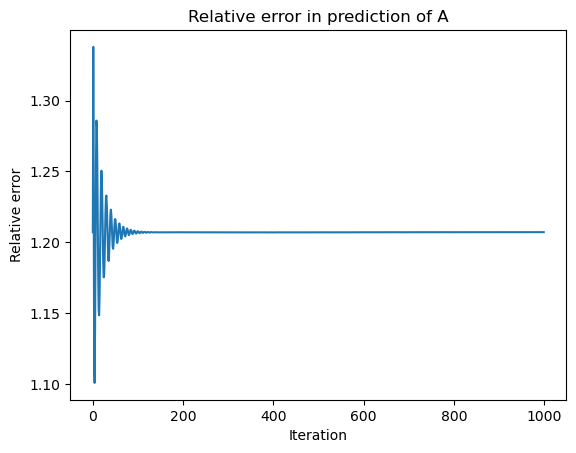

In [86]:
plt.plot(torch.tensor(a_comparison).detach().numpy());
plt.title("Relative error in prediction of A")
plt.xlabel("Iteration")
plt.ylabel("Relative error");

### (d)

In [183]:
# TODO: Train network on the full training dataset
# recreate model
trn_dataloader = DataLoader(amp_dataset(trn_datf, trn_amp), batch_size=64, shuffle=True)
model = amp_net().to(device).double()
# when re-running this cell, we must re-initialise the model first.
criterion = torch.nn.MSELoss()  # is a callable which takes tensors x, y and returns a scalar loss
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)  # is an object of class Adam

loss_history = []
a_comparison = []
myiter = tqdm(range(1000));
for epoch in myiter:
    for x, A in iter(trn_dataloader):
        x, A = x.to(device), A.to(device)
        # zero out the gradients which we will update (the models learnable parameters)
        # the optimiser object keeps track of the parameters which it should update
        optimiser.zero_grad()
        # get prediction for batch x
        outputs = model(x)
        # get loss of prediction relative to target A
        # it is VERY IMPORTANT to FLATTEN (so that the dimensions of outputs and A match)
        loss = criterion(outputs.flatten(), A)
        loss.backward()  # compute gradients of loss with respect to all learnable parameters
        # update the learnable parameters
        optimiser.step()

        loss_history.append(loss.item())
        a_comparison.append(((outputs.flatten() - A) / A).mean())

    myiter.set_description(f"Loss: {loss.item():.3f}");

Loss: 0.071: 100%|██████████| 1000/1000 [23:23<00:00,  1.40s/it]  


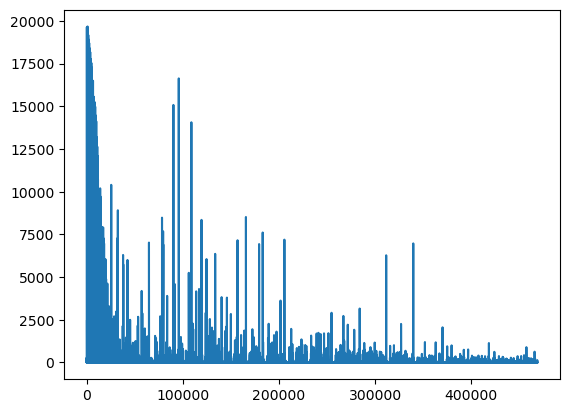

In [184]:
plt.plot(loss_history);

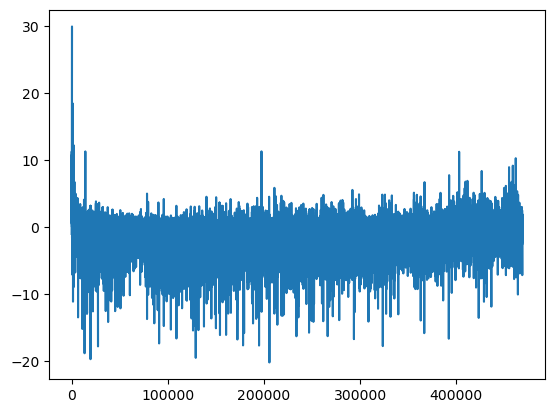

In [185]:
# TODO: Plot loss and amplitude histogram
plt.plot(torch.tensor(a_comparison).detach().numpy());

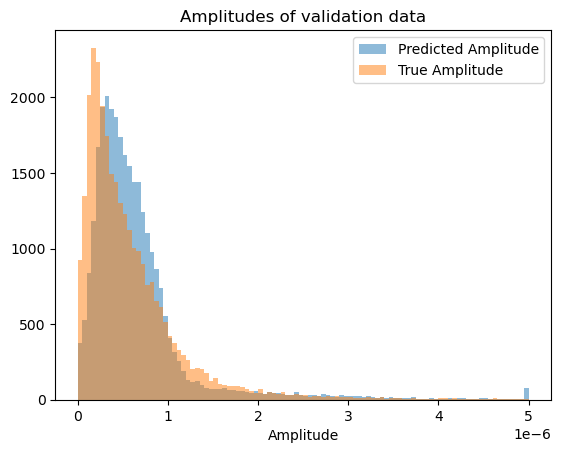

In [186]:
amps = []
for x, A in val_dataloader:
    amps.append(model(x).flatten().detach().numpy())
amps = np.concatenate(amps)
plt.hist(undo_preprocess_A(amps), bins=100, range=(0, 5e-6), label="Predicted Amplitude", alpha=0.5);
plt.hist(val_amp, bins=100, range=(0, 5e-6), label="True Amplitude", alpha=0.5);
plt.title("Amplitudes of validation data");
plt.xlabel("Amplitude")
plt.legend();

### (e)

In [59]:
# TODO: create dataloaders with reduced dataset

batch_size = 64
trn_dataloader_reduced = ...
val_dataloader_reduced = ...
tst_dataloader_reduced = ...

In [ ]:
# TODO: Train model on reduced dataset

In [ ]:
# TODO: Evaluate model

In [ ]:
# TODO: Implement your regularization approach, train a model and evaluate it